## Symplectic Euler Integrator

In [1]:
def classicInt(z,f1,f2,h):
  ## classical symplectic Euler scheme
    dim = int(len(z)/2)
    q=z[:dim]
    p=z[dim:]
    fstage = lambda stg: h * f1(np.block([q + stg, p]))

    stageold=np.zeros(dim) 
    stage = fstage(stageold) +0.
    # Iter = 0

    # while (np.amax(abs(stage - stageold)) > 1e-10 and Iter<400):
    #   stageold = stage+0.
    #   stage = fstage(stage)+0.
    #   Iter = Iter+1
    q = q+stage
    p = p + h*f2(np.block([q,p]))
    return np.block([q,p])

def classicTrajectory(z,f1,f2,h,N=10,n_h=1):
  ## trajectory computed with classicInt
  h_gen = h/n_h
  z = z.reshape(1,-1)[0]
  trj = np.zeros((len(z),N+1))
  trj[:,0] = z.copy()

  for i in range(0,N):
    for j in range(0,int(n_h)):
      trj[:,i+1] = classicInt(trj[:,i].copy(),f1,f2,h_gen)
  return trj[:, :-1], trj[:, 1:]


## Stormer Verlet Integrator

In [2]:
def iterator(fstage,dim,maxiters):
  stageold=np.zeros(dim) 
  stage = fstage(stageold) +0.
  Iter = 0
  while (np.amax(abs(stage - stageold)) > 1e-10 and Iter<maxiters):
    stageold = stage+0.
    stage = fstage(stage)+0.
    Iter = Iter+1
  return stage

def StormerInt(z,f1,f2,h,maxiters):
	## classical symplectic Euler scheme
    dim = int(len(z)/2)
    x=z[:dim]
    y=z[dim:]
    ystage = lambda stg: h/2 * f2(np.block([x, y + stg]))
    stage=iterator(ystage,dim,maxiters)
    y=y+stage

    xstage = lambda stg: h/2 * (f1(np.block([x, y]))+f1(np.block([x+stg, y])))
    stage=iterator(xstage,dim,maxiters)
    x=x+stage
    y=y+h/2*f2(np.block([x, y]))
    return np.block([x,y])

def StormerTrajectory(z,f1,f2,h,N=10,n_h=1,maxiters=100):
	## trajectory computed with classicInt
  h_gen = h/n_h
  z = z.reshape(1,-1)[0]
  trj = np.zeros((len(z),N+1))
  trj[:,0] = z.copy()

  for i in range(0,N):
    for j in range(0,int(n_h)):
      trj[:,i+1] = StormerInt(trj[:,i].copy(),f1,f2,h_gen,maxiters)
  return trj[:, :-1], trj[:, 1:]



## Fourth order symplectic integrator

In [3]:
def fourth_order(z, f1, f2, h, eps=0.1):
    dim = int(len(z)/2)   
    kq = z[:dim]
    kp = z[dim:]
    c = np.array([0.5/(2.-2.**(1./3.)),
         (0.5-2.**(-2./3.))/(2.-2.**(1./3.)),
         (0.5-2.**(-2./3.))/(2.-2.**(1./3.)),
         0.5/(2.-2.**(1./3.))])
    d = np.array([1./(2.-2.**(1./3.)),
         -2.**(1./3.)/(2.-2.**(1./3.)),
         1./(2.-2.**(1./3.)),0.])
    for i_step in range(int(1)):
        for j in range(4):
            tp = kp
            tq = kq + c[j] * f1(z) * h
            kp = tp + d[j] * f2(z) * h
            kq = tq
    return np.block([kq, kp])


def FourthOrder(z,f1,f2,h,N=10,n_h=1,maxiters=100):
	## trajectory computed with classicInt
  h_gen = h/n_h
  z = z.reshape(1,-1)[0]
  trj = np.zeros((len(z),N+1))
  trj[:,0] = z.copy()

  for i in range(0,N):
    for j in range(0,int(n_h)):
      trj[:,i+1] = fourth_order(trj[:,i].copy(),f1,f2,h_gen,maxiters)
  return trj[:, :-1], trj[:, 1:]

The Anisotropic Kepler ODE problem: https://link.springer.com/article/10.1007/s10569-016-9722-z

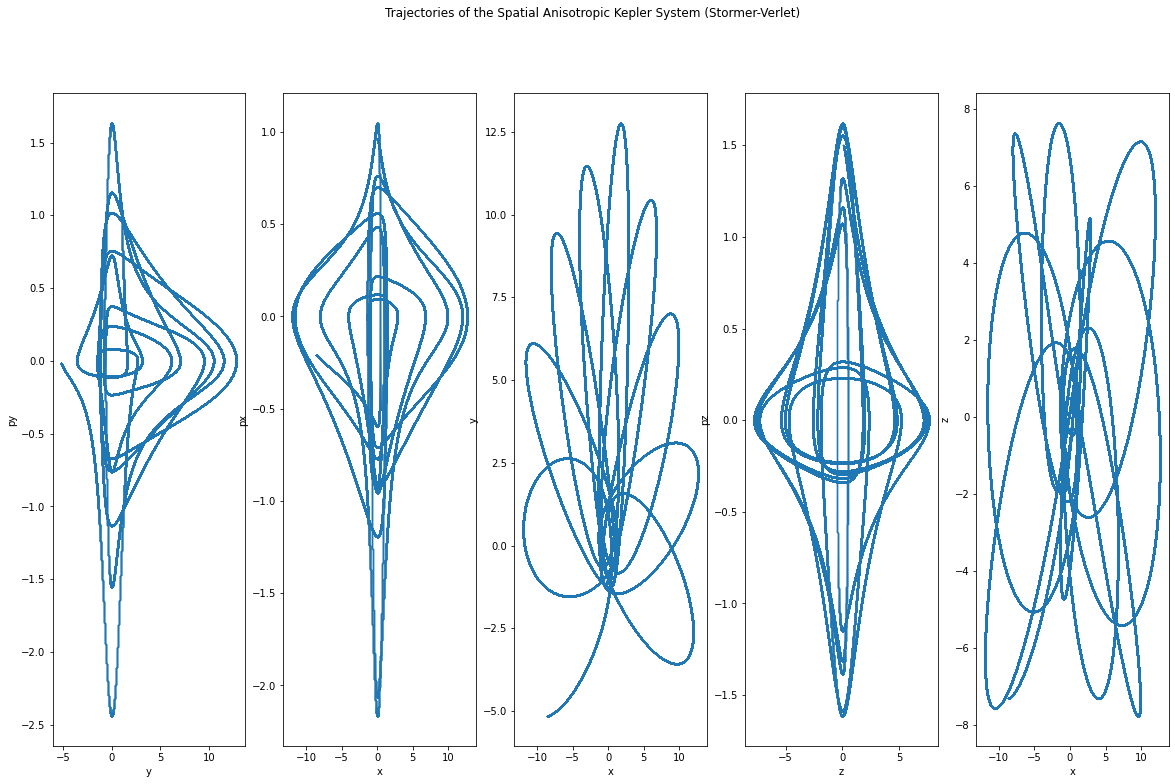

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

H = lambda x: 0.5*(x[3]**2 + x[4]**2 + x[5]**2) - 2.25 / (1*(x[0]**2+x[1]**2)+1.5*(x[2]))**0.5
f1 = lambda x: np.asarray([x[3], x[4], x[5]])
f2 = lambda x: np.asarray([-2.25*1.*x[0]*(1*(x[0]**2+x[1]**2)+1.5*(x[2]**2))**(-1.5), 
                           -2.25*1.*x[1]*(1*(x[0]**2+x[1]**2)+1.5*(x[2]**2))**(-1.5),
                           -2.25*1.5*x[2]*(1*(x[0]**2+x[1]**2)+1.5*(x[2]**2))**(-1.5)])
p1 = lambda x: np.sqrt((-0.01 + 2.25 / (1*(x[0]**2+x[1]**2)+1.5*(x[2]))**0.5)*2 -x[4]**2 -x[5]**2)

inp = np.array([0, 1, 0.1, 1.2, 1., 1.5])
inp[3] = p1(inp) # specifically E = -0.01

fig, ax = plt.subplots(1,5,figsize = (20,12))
soln = StormerTrajectory(inp,f1,f2,0.0001,N=8000000,n_h=1)
ax[0].scatter(np.asarray(soln)[0][1,:], np.asarray(soln)[0][4,:], marker = '.', s=0.1)
ax[1].scatter(np.asarray(soln)[0][0,:], np.asarray(soln)[0][3,:], marker = '.', s=0.1)
ax[2].scatter(np.asarray(soln)[0][0,:], np.asarray(soln)[0][1,:], marker = '.', s=0.1)
ax[3].scatter(np.asarray(soln)[0][2,:], np.asarray(soln)[0][5,:], marker = '.', s=0.1)
ax[4].scatter(np.asarray(soln)[0][0,:], np.asarray(soln)[0][2,:], marker = '.', s=0.1)
fig.suptitle("Trajectories of the Spatial Anisotropic Kepler System (Stormer-Verlet)")
ax[0].set_xlabel("y")
ax[0].set_ylabel("py")
ax[1].set_xlabel("x")
ax[1].set_ylabel("px")
ax[2].set_xlabel("x")
ax[2].set_ylabel("y")
ax[3].set_xlabel("z")
ax[3].set_ylabel("pz")
ax[4].set_xlabel("x")
ax[4].set_ylabel("z")
plt.show()



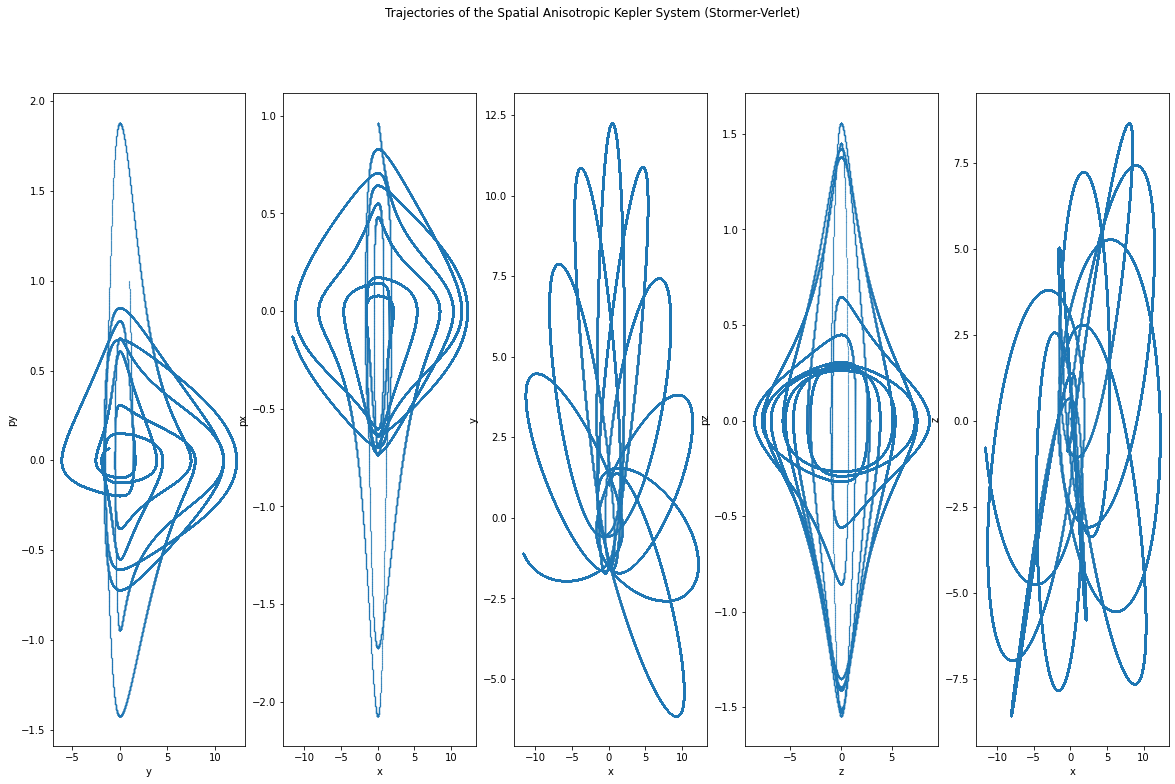

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

H = lambda x: 0.5*(x[3]**2 + x[4]**2 + x[5]**2) - 2.25 / (1*(x[0]**2+x[1]**2)+1.5*(x[2]))**0.5
f1 = lambda x: np.asarray([x[3], x[4], x[5]])
f2 = lambda x: np.asarray([-2.25*1.*x[0]*(1*(x[0]**2+x[1]**2)+1.5*(x[2]**2))**(-1.5), 
                           -2.25*1.*x[1]*(1*(x[0]**2+x[1]**2)+1.5*(x[2]**2))**(-1.5),
                           -2.25*1.5*x[2]*(1*(x[0]**2+x[1]**2)+1.5*(x[2]**2))**(-1.5)])
p1 = lambda x: np.sqrt((-0.01 + 2.25 / (1*(x[0]**2+x[1]**2)+1.5*(x[2]))**0.5)*2 -x[4]**2 -x[5]**2)

inp = np.array([0, 1, 0.1, 1.2, 1., -1.5])
inp[3] = p1(inp) # specifically E = -0.01

fig, ax = plt.subplots(1,5,figsize = (20,12))
soln = StormerTrajectory(inp,f1,f2,0.001,N=800000,n_h=1)
ax[0].scatter(np.asarray(soln)[0][1,:], np.asarray(soln)[0][4,:], marker = '.', s=0.1)
ax[1].scatter(np.asarray(soln)[0][0,:], np.asarray(soln)[0][3,:], marker = '.', s=0.1)
ax[2].scatter(np.asarray(soln)[0][0,:], np.asarray(soln)[0][1,:], marker = '.', s=0.1)
ax[3].scatter(np.asarray(soln)[0][2,:], np.asarray(soln)[0][5,:], marker = '.', s=0.1)
ax[4].scatter(np.asarray(soln)[0][0,:], np.asarray(soln)[0][2,:], marker = '.', s=0.1)
fig.suptitle("Trajectories of the Spatial Anisotropic Kepler System (Stormer-Verlet)")
ax[0].set_xlabel("y")
ax[0].set_ylabel("py")
ax[1].set_xlabel("x")
ax[1].set_ylabel("px")
ax[2].set_xlabel("x")
ax[2].set_ylabel("y")
ax[3].set_xlabel("z")
ax[3].set_ylabel("pz")
ax[4].set_xlabel("x")
ax[4].set_ylabel("z")
plt.show()



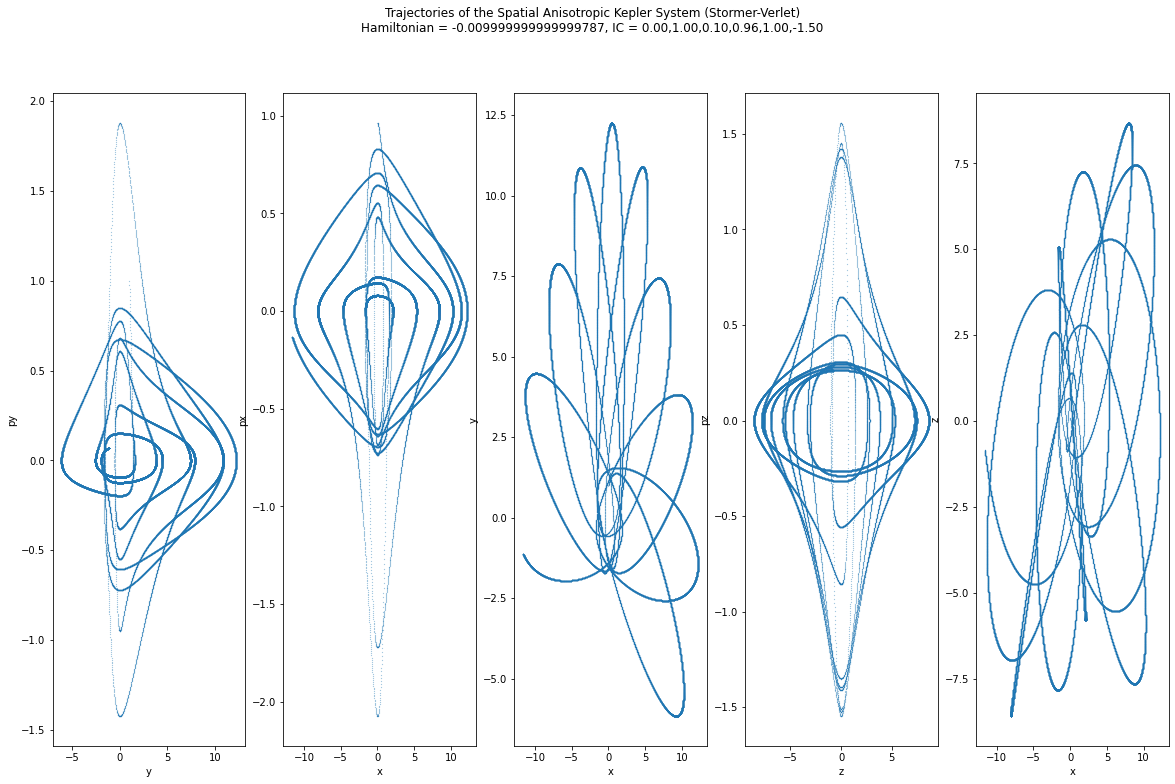

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

H = lambda x: 0.5*(x[3]**2 + x[4]**2 + x[5]**2) - 2.25 / (1*(x[0]**2+x[1]**2)+1.5*(x[2]))**0.5
f1 = lambda x: np.asarray([x[3], x[4], x[5]])
f2 = lambda x: np.asarray([-2.25*1.*x[0]*(1*(x[0]**2+x[1]**2)+1.5*(x[2]**2))**(-1.5), 
                           -2.25*1.*x[1]*(1*(x[0]**2+x[1]**2)+1.5*(x[2]**2))**(-1.5),
                           -2.25*1.5*x[2]*(1*(x[0]**2+x[1]**2)+1.5*(x[2]**2))**(-1.5)])
p1 = lambda x: np.sqrt((-0.01 + 2.25 / (1*(x[0]**2+x[1]**2)+1.5*(x[2]))**0.5)*2 -x[4]**2 -x[5]**2)

inp = np.array([0, 1, 0.1, 1.2, 1., -1.5])
inp[3] = p1(inp) # specifically E = -0.01

fig, ax = plt.subplots(1,5,figsize = (20,12))
soln = StormerTrajectory(inp,f1,f2,0.01,N=80000,n_h=1)
ax[0].scatter(np.asarray(soln)[0][1,:], np.asarray(soln)[0][4,:], marker = '.', s=0.1)
ax[1].scatter(np.asarray(soln)[0][0,:], np.asarray(soln)[0][3,:], marker = '.', s=0.1)
ax[2].scatter(np.asarray(soln)[0][0,:], np.asarray(soln)[0][1,:], marker = '.', s=0.1)
ax[3].scatter(np.asarray(soln)[0][2,:], np.asarray(soln)[0][5,:], marker = '.', s=0.1)
ax[4].scatter(np.asarray(soln)[0][0,:], np.asarray(soln)[0][2,:], marker = '.', s=0.1)
fig.suptitle("Trajectories of the Spatial Anisotropic Kepler System (Stormer-Verlet)\nHamiltonian = %s, IC = %.2f,%.2f,%.2f,%.2f,%.2f,%.2f" %(H(inp), inp[0], inp[1], inp[2], inp[3], inp[4], inp[5]))
ax[0].set_xlabel("y")
ax[0].set_ylabel("py")
ax[1].set_xlabel("x")
ax[1].set_ylabel("px")
ax[2].set_xlabel("x")
ax[2].set_ylabel("y")
ax[3].set_xlabel("z")
ax[3].set_ylabel("pz")
ax[4].set_xlabel("x")
ax[4].set_ylabel("z")
plt.show()



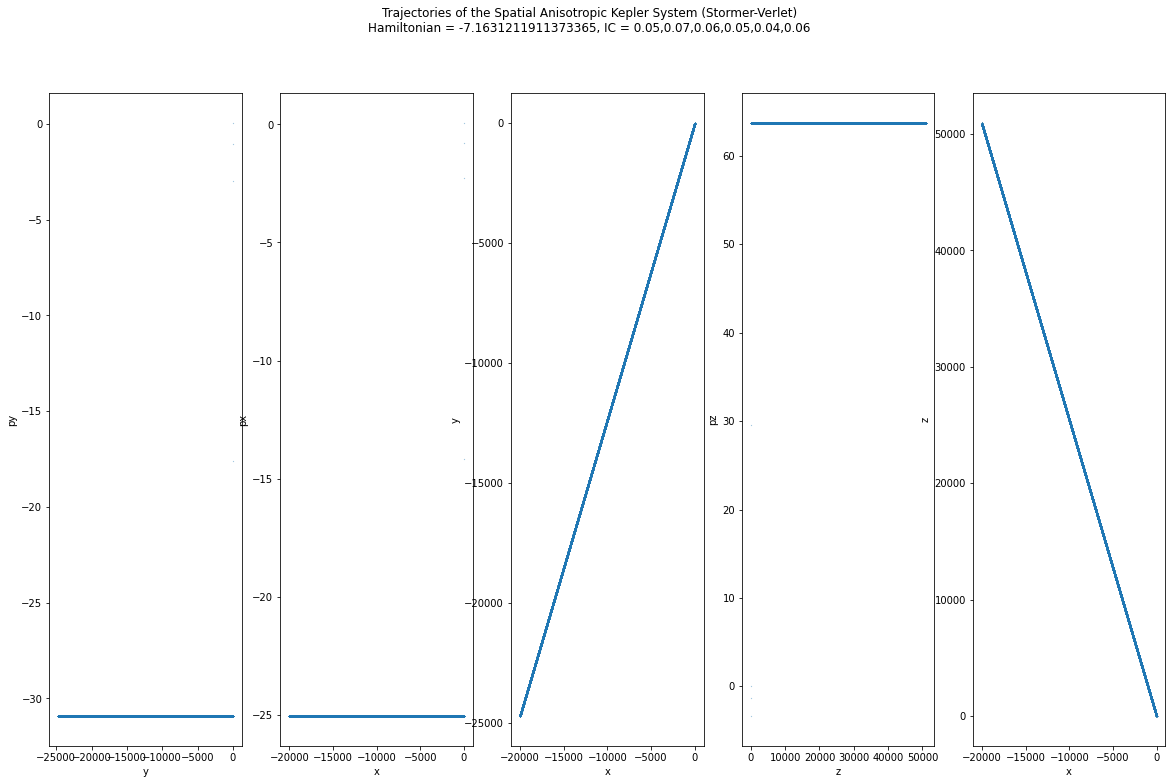

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

H = lambda x: 0.5*(x[3]**2 + x[4]**2 + x[5]**2) - 2.25 / (1*(x[0]**2+x[1]**2)+1.5*(x[2]))**0.5
f1 = lambda x: np.asarray([x[3], x[4], x[5]])
f2 = lambda x: np.asarray([-2.25*1.*x[0]*(1*(x[0]**2+x[1]**2)+1.5*(x[2]**2))**(-1.5), 
                           -2.25*1.*x[1]*(1*(x[0]**2+x[1]**2)+1.5*(x[2]**2))**(-1.5),
                           -2.25*1.5*x[2]*(1*(x[0]**2+x[1]**2)+1.5*(x[2]**2))**(-1.5)])
p1 = lambda x: np.sqrt((-0.01 + 2.25 / (1*(x[0]**2+x[1]**2)+1.5*(x[2]))**0.5)*2 -x[4]**2 -x[5]**2)

np.random.seed(0)
inp = np.random.rand(6)*0.1

fig, ax = plt.subplots(1,5,figsize = (20,12))
soln = StormerTrajectory(inp,f1,f2,0.01,N=80000,n_h=1)
ax[0].scatter(np.asarray(soln)[0][1,:], np.asarray(soln)[0][4,:], marker = '.', s=0.1)
ax[1].scatter(np.asarray(soln)[0][0,:], np.asarray(soln)[0][3,:], marker = '.', s=0.1)
ax[2].scatter(np.asarray(soln)[0][0,:], np.asarray(soln)[0][1,:], marker = '.', s=0.1)
ax[3].scatter(np.asarray(soln)[0][2,:], np.asarray(soln)[0][5,:], marker = '.', s=0.1)
ax[4].scatter(np.asarray(soln)[0][0,:], np.asarray(soln)[0][2,:], marker = '.', s=0.1)
fig.suptitle("Trajectories of the Spatial Anisotropic Kepler System (Stormer-Verlet)\nHamiltonian = %s, IC = %.2f,%.2f,%.2f,%.2f,%.2f,%.2f" %(H(inp), inp[0], inp[1], inp[2], inp[3], inp[4], inp[5]))
ax[0].set_xlabel("y")
ax[0].set_ylabel("py")
ax[1].set_xlabel("x")
ax[1].set_ylabel("px")
ax[2].set_xlabel("x")
ax[2].set_ylabel("y")
ax[3].set_xlabel("z")
ax[3].set_ylabel("pz")
ax[4].set_xlabel("x")
ax[4].set_ylabel("z")
plt.show()



https://cdn.intechopen.com/pdfs/43374/InTech-Classical_and_quantum_correspondence_in_anisotropic_kepler_problem.pdf

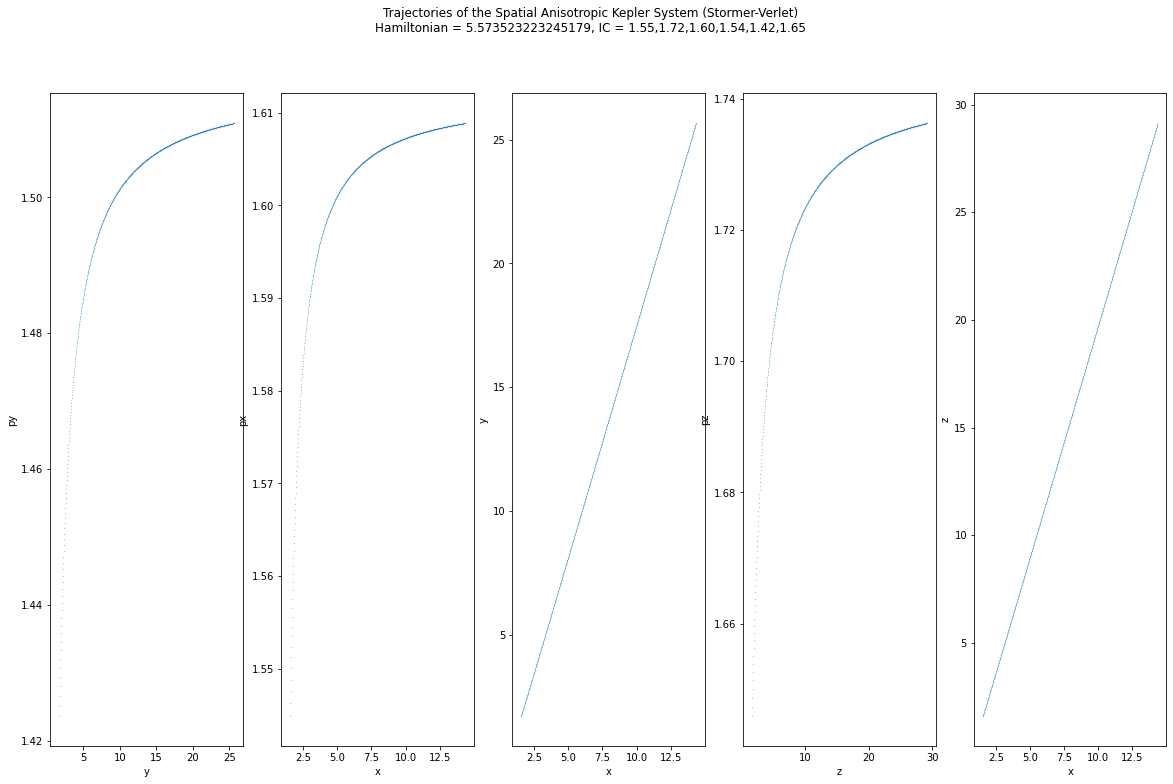

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

H = lambda x: 0.5*(x[3]**2) + x[4]**2 + x[5]**2 - 1./ (x[0]**2+x[1]**2+x[2]**2)**0.5
f1 = lambda x: np.asarray([x[3], 2*x[4], 2*x[5]])
f2 = lambda x: np.asarray([2*x[0]*(x[0]**2+x[1]**2+x[2]**2)**(-1.5), 
                           2*x[1]*(x[0]**2+x[1]**2+x[2]**2)**(-1.5),
                           2*x[2]*(x[0]**2+x[1]**2+x[2]**2)**(-1.5)])
# p1 = lambda x: np.sqrt((-0.01 + 2.25 / (1*(x[0]**2+x[1]**2)+1.5*(x[2]))**0.5)*2 -x[4]**2 -x[5]**2)


np.random.seed(0)
inp = np.random.rand(6)+1

fig, ax = plt.subplots(1,5,figsize = (20,12))
soln = StormerTrajectory(inp,f1,f2,0.01,N=800,n_h=1)
ax[0].scatter(np.asarray(soln)[0][1,:], np.asarray(soln)[0][4,:], marker = '.', s=0.1)
ax[1].scatter(np.asarray(soln)[0][0,:], np.asarray(soln)[0][3,:], marker = '.', s=0.1)
ax[2].scatter(np.asarray(soln)[0][0,:], np.asarray(soln)[0][1,:], marker = '.', s=0.1)
ax[3].scatter(np.asarray(soln)[0][2,:], np.asarray(soln)[0][5,:], marker = '.', s=0.1)
ax[4].scatter(np.asarray(soln)[0][0,:], np.asarray(soln)[0][2,:], marker = '.', s=0.1)
fig.suptitle("Trajectories of the Spatial Anisotropic Kepler System (Stormer-Verlet)\nHamiltonian = %s, IC = %.2f,%.2f,%.2f,%.2f,%.2f,%.2f" %(H(inp), inp[0], inp[1], inp[2], inp[3], inp[4], inp[5]))
ax[0].set_xlabel("y")
ax[0].set_ylabel("py")
ax[1].set_xlabel("x")
ax[1].set_ylabel("px")
ax[2].set_xlabel("x")
ax[2].set_ylabel("y")
ax[3].set_xlabel("z")
ax[3].set_ylabel("pz")
ax[4].set_xlabel("x")
ax[4].set_ylabel("z")
plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

H = lambda x: 0.5*(x[3]**2 + x[4]**2 + x[5]**2) - 2.25 / (1*(x[0]**2+x[1]**2)+1.5*(x[2]))**0.5
f1 = lambda x: np.asarray([x[3], x[4], x[5]])
f2 = lambda x: np.asarray([-2.25*1.*x[0]*(1*(x[0]**2+x[1]**2)+1.5*(x[2]**2))**(-1.5), 
                           -2.25*1.*x[1]*(1*(x[0]**2+x[1]**2)+1.5*(x[2]**2))**(-1.5),
                           -2.25*1.5*x[2]*(1*(x[0]**2+x[1]**2)+1.5*(x[2]**2))**(-1.5)])
p1 = lambda x: np.sqrt((-0.01 + 2.25 / (1*(x[0]**2+x[1]**2)+1.5*(x[2]))**0.5)*2 -x[4]**2 -x[5]**2)

np.random.seed(0)
inp = np.rand.random(6)*0.1

fig, ax = plt.subplots(1,5,figsize = (20,12))
soln = StormerTrajectory(inp,f1,f2,0.001,N=8000000,n_h=1)
ax[0].scatter(np.asarray(soln)[0][1,:], np.asarray(soln)[0][4,:], marker = '.', s=0.1)
ax[1].scatter(np.asarray(soln)[0][0,:], np.asarray(soln)[0][3,:], marker = '.', s=0.1)
ax[2].scatter(np.asarray(soln)[0][0,:], np.asarray(soln)[0][1,:], marker = '.', s=0.1)
ax[3].scatter(np.asarray(soln)[0][2,:], np.asarray(soln)[0][5,:], marker = '.', s=0.1)
ax[4].scatter(np.asarray(soln)[0][0,:], np.asarray(soln)[0][2,:], marker = '.', s=0.1)
fig.suptitle("Trajectories of the Spatial Anisotropic Kepler System (Stormer-Verlet)\nHamiltonian = %s, IC = %.2f,%.2f,%.2f,%.2f,%.2f,%.2f" %(H(inp), inp[0], inp[1], inp[2], inp[3], inp[4], inp[5]))
ax[0].set_xlabel("y")
ax[0].set_ylabel("py")
ax[1].set_xlabel("x")
ax[1].set_ylabel("px")
ax[2].set_xlabel("x")
ax[2].set_ylabel("y")
ax[3].set_xlabel("z")
ax[3].set_ylabel("pz")
ax[4].set_xlabel("x")
ax[4].set_ylabel("z")
plt.show()



initial conditions:  [ 0.  -1.5 -0.5  0.2 -1.  -0.2]
Energy:  -1.2971173070873836


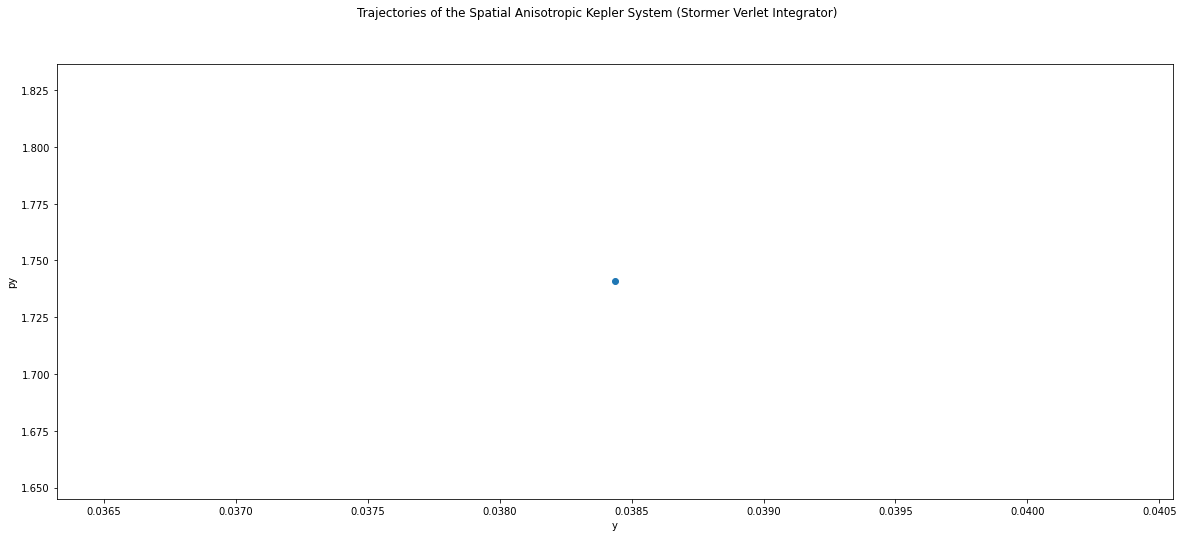

In [ ]:
from tqdm import tqdm
def findcrossings(data):
    # returns indices in 1D data set where the data crossed zero. Useful for generating Poincare map at 0
    prb = list()
    for ii in range(len(data)-1):
        if (data[ii] > 0)&(data[ii+1] < 0):
            prb.append(ii)
        if (data[ii] < 0)& (data[ii+1] > 0):
            prb.append(ii)
    return np.array(prb)

np.random.seed(0)

H = lambda x: 0.5*(x[3]**2 + x[4]**2 + x[5]**2) - 2.25 / (1*(x[0]**2+x[1]**2)+1.5*(x[2]))**0.5
f1 = lambda x: np.asarray([x[3], x[4], x[5]])
f2 = lambda x: np.asarray([-2.25*1.*x[0]*(1*(x[0]**2+x[1]**2)+1.5*(x[2]**2))**(-1.5), 
                           -2.25*1.*x[1]*(1*(x[0]**2+x[1]**2)+1.5*(x[2]**2))**(-1.5),
                           -2.25*1.5*x[2]*(1*(x[0]**2+x[1]**2)+1.5*(x[2]**2))**(-1.5)])
p1 = lambda x: np.sqrt((-0.01 + 2.25 / (1*(x[0]**2+x[1]**2)+1.5*(x[2]))**0.5)*2 -x[4]**2 -x[5]**2)

fig, ax = plt.subplots(1,1,figsize = (20,8))
# for inp in tqdm(range(50)): # number of trajectories
  # inp = np.random.rand(6)*4-2.
  # inp[0] = 0
  # inp[3] = p1(inp)
  # while H(inp)>0 or (-0.01 + 2.25 / (1*(inp[0]**2+inp[1]**2)+1.5*(inp[2]))**0.5)*2 -inp[4]**2 -inp[5]**2 <0:
  #   inp = np.random.rand(6)*4-2.
  #   inp[0] = 0
  #   inp[3] = p1(inp)
inp = np.array([0,-1.5,-0.5,0.2,-1,-0.2])
print("initial conditions: ", inp)
print("Energy: ", H(inp))
soln = StormerTrajectory(inp,f1,f2,0.01,N=1000000,n_h=1)
xcrossings = findcrossings(np.asarray(soln[0])[0,:])
yints = [.5*(np.asarray(soln[0])[1, cross] + np.asarray(soln[0])[1, cross+1]) for cross in xcrossings] # average y for each crossing
pyints = [.5*(np.asarray(soln[0])[4, cross] + np.asarray(soln[0])[4, cross+1]) for cross in xcrossings] #average ydot for each crossing
ax.scatter(yints, pyints)
fig.suptitle("Trajectories of the Spatial Anisotropic Kepler System (Stormer Verlet Integrator)")
ax.set_xlabel("y")
ax.set_ylabel("py")
plt.show()

The anisotropic Kepler problem (AKP) was introduced by Gutzwiller (1967, 1969, 1970, 1971, 1977, 1989, 1990) as a possible example of ‘hard chaos’, i.e., a system without stable periodic orbits. 

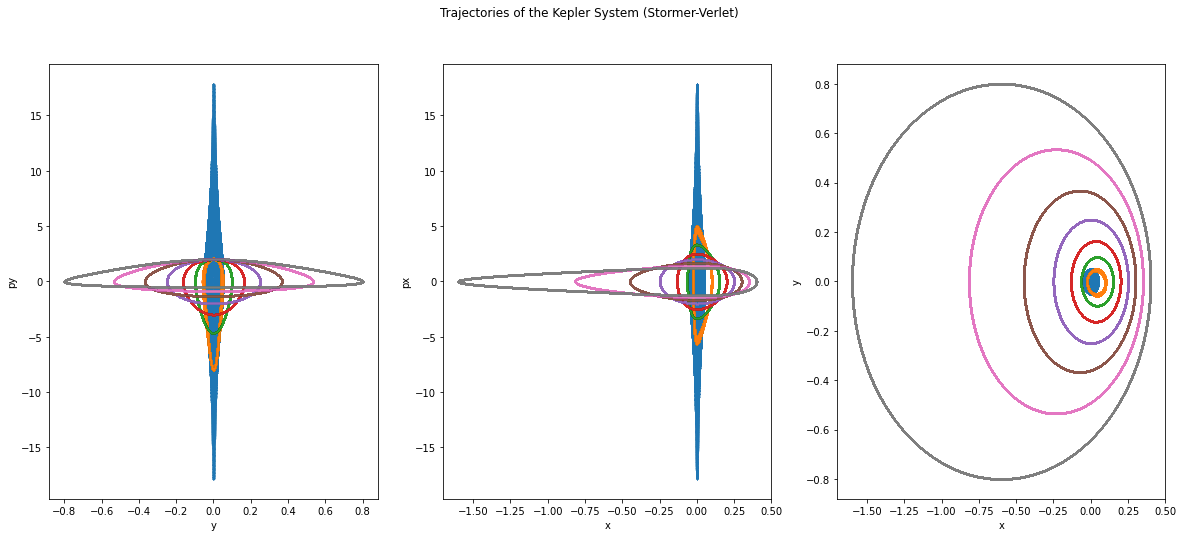

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate


H = lambda x: 0.5 * ( x[2]**2 + x[3]**2 ) - 1.0 / np.sqrt ( x[0]**2 + x[1]**2 )
f1 = lambda x: np.asarray([x[2], x[3]])
f2 = lambda x: np.asarray([-x[0]*(x[0]**2+x[1]**2)**(-1.5), -x[1]*(x[0]**2+x[1]**2)**(-1.5)])

# fig, ax = plt.subplots(1,3,figsize = (20,8))
# for i in np.linspace(-0.1,0.1,8): # number of trajectories
#     inp, lmbda = np.array([1-3/5, 0, 0, np.sqrt((1+3/5)/(1-3/5))]), 1
#     soln = FourthOrder(inp,f1,f2,0.0001,N=80000,n_h=1)
#     ax[0].scatter(np.asarray(soln)[0][1,:], np.asarray(soln)[0][3,:], marker = '.', s=0.1)
#     ax[1].scatter(np.asarray(soln)[0][0,:], np.asarray(soln)[0][2,:], marker = '.', s=0.1)
#     ax[2].scatter(np.asarray(soln)[0][0,:], np.asarray(soln)[0][1,:], marker = '.', s=0.1)
# fig.suptitle("Trajectories of the Kepler System (4-th order symplectic integrator)")
# ax[0].set_xlabel("y")
# ax[0].set_ylabel("py")
# ax[1].set_xlabel("x")
# ax[1].set_ylabel("px")
# ax[2].set_xlabel("x")
# ax[2].set_ylabel("y")
# plt.show()

fig, ax = plt.subplots(1,3,figsize = (20,8))
for i in np.linspace(0.05,0.4,8): # number of trajectories
    inp, lmbda = np.array([i, 0, 0, np.sqrt((1+3/5)/(1-3/5))]), 1
    soln = StormerTrajectory(inp,f1,f2,0.0001,N=800000,n_h=1)
    ax[0].scatter(np.asarray(soln)[0][1,:], np.asarray(soln)[0][3,:], marker = '.', s=0.1)
    ax[1].scatter(np.asarray(soln)[0][0,:], np.asarray(soln)[0][2,:], marker = '.', s=0.1)
    ax[2].scatter(np.asarray(soln)[0][0,:], np.asarray(soln)[0][1,:], marker = '.', s=0.1)
fig.suptitle("Trajectories of the Kepler System (Stormer-Verlet)")
ax[0].set_xlabel("y")
ax[0].set_ylabel("py")
ax[1].set_xlabel("x")
ax[1].set_ylabel("px")
ax[2].set_xlabel("x")
ax[2].set_ylabel("y")
plt.show()

# fig, ax = plt.subplots(1,3,figsize = (20,8))
# for i in np.linspace(-0.1,0.1,8): # number of trajectories
#     inp, lmbda = np.array([0,i,0,0]), 1
#     soln = classicTrajectory(inp,f1,f2,0.0001,N=800000,n_h=1)
#     ax[0].scatter(np.asarray(soln)[0][1,:], np.asarray(soln)[0][3,:], marker = '.', s=0.1)
#     ax[1].scatter(np.asarray(soln)[0][0,:], np.asarray(soln)[0][2,:], marker = '.', s=0.1)
#     ax[2].scatter(np.asarray(soln)[0][0,:], np.asarray(soln)[0][1,:], marker = '.', s=0.1)
# fig.suptitle("Trajectories of the Kepler System (Symplectic Euler)")
# ax[0].set_xlabel("y")
# ax[0].set_ylabel("py")
# ax[1].set_xlabel("x")
# ax[1].set_ylabel("px")
# ax[2].set_xlabel("x")
# ax[2].set_ylabel("y")
# plt.show()

100%|██████████| 12/12 [27:31<00:00, 137.63s/it]


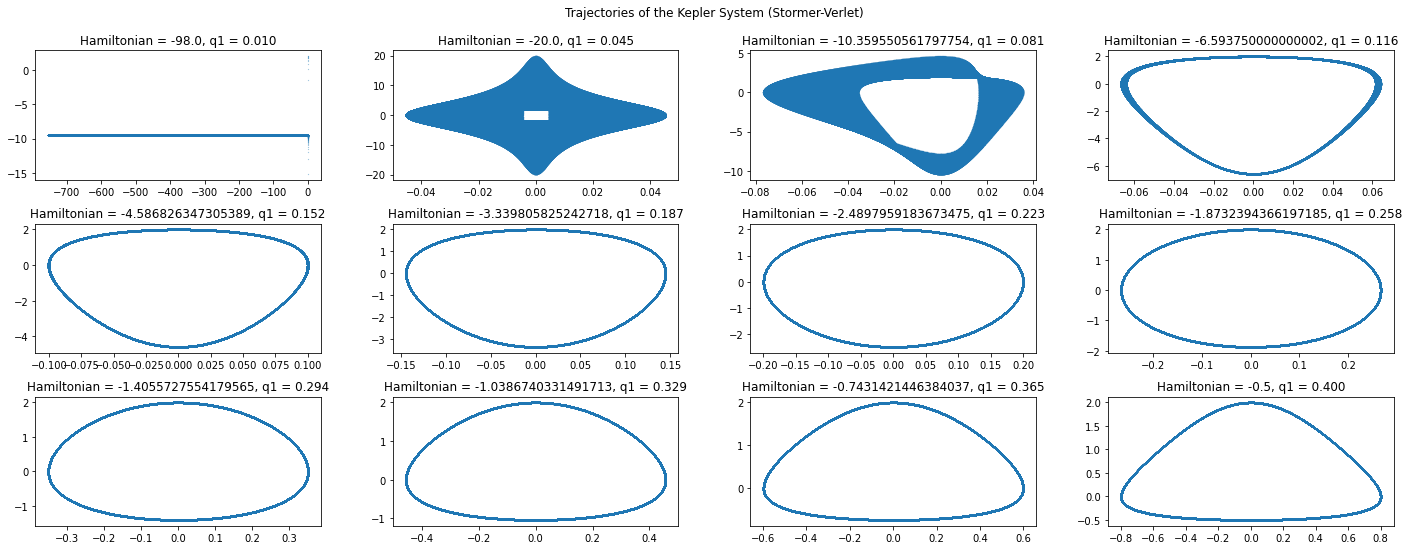

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from tqdm import tqdm

H = lambda x: 0.5 * ( x[2]**2 + x[3]**2 ) - 1.0 / np.sqrt ( x[0]**2 + x[1]**2 )
f1 = lambda x: np.asarray([x[2], x[3]])
f2 = lambda x: np.asarray([-x[0]*(x[0]**2+x[1]**2)**(-1.5), -x[1]*(x[0]**2+x[1]**2)**(-1.5)])


fig, ax = plt.subplots(3,4,figsize = (20,8))
store = np.linspace(0.01,0.4,12)
for i in tqdm(range(len(store))): # number of trajectories
    inp = np.array([store[i], 0, 0, np.sqrt((1+3/5)/(1-3/5))])
    soln = StormerTrajectory(inp,f1,f2,0.0001,N=800000,n_h=1)
    ax[i//4][i%4].scatter(np.asarray(soln)[0][1,:], np.asarray(soln)[0][3,:], marker = '.', s=0.1)
    ax[i//4][i%4].title.set_text("Hamiltonian = %s, q1 = %.3f" %(H(inp), store[i]))
    # ax[1].scatter(np.asarray(soln)[0][0,:], np.asarray(soln)[0][2,:], marker = '.', s=0.1)
    # ax[2].scatter(np.asarray(soln)[0][0,:], np.asarray(soln)[0][1,:], marker = '.', s=0.1)
fig.suptitle("Trajectories of the Kepler System (Stormer-Verlet)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

^ From the above plots, it appears that q1 cannot be too small.

100%|██████████| 12/12 [27:38<00:00, 138.17s/it]


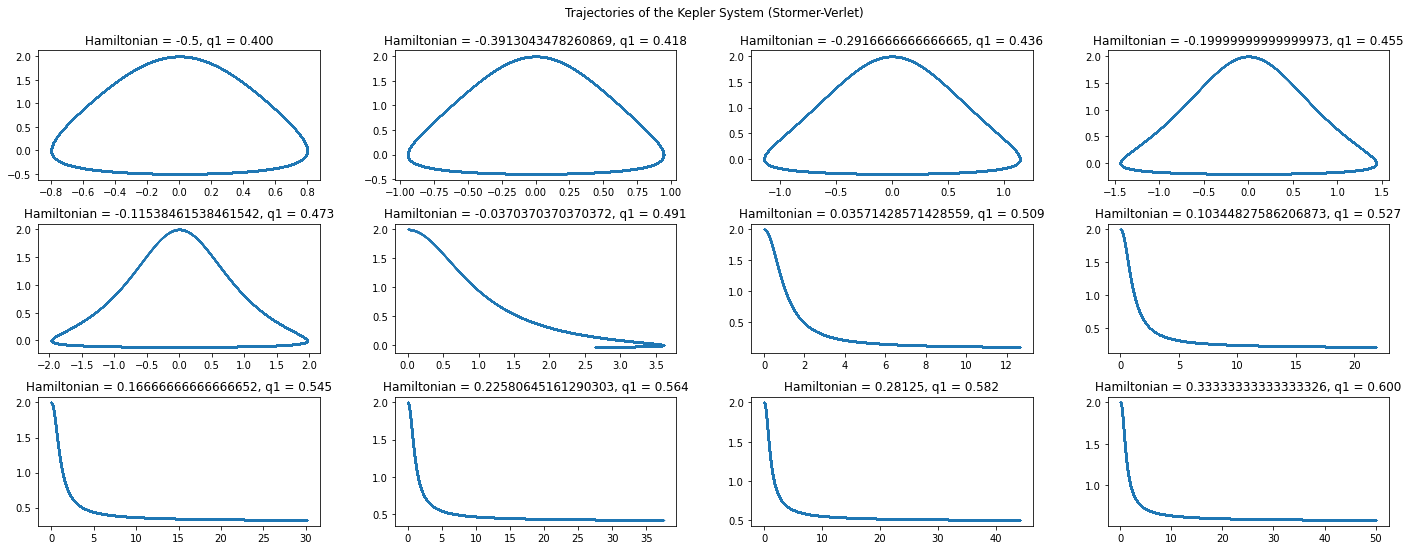

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from tqdm import tqdm

H = lambda x: 0.5 * ( x[2]**2 + x[3]**2 ) - 1.0 / np.sqrt ( x[0]**2 + x[1]**2 )
f1 = lambda x: np.asarray([x[2], x[3]])
f2 = lambda x: np.asarray([-x[0]*(x[0]**2+x[1]**2)**(-1.5), -x[1]*(x[0]**2+x[1]**2)**(-1.5)])


fig, ax = plt.subplots(3,4,figsize = (20,8))
store = np.linspace(0.4,0.6,12)
for i in tqdm(range(len(store))): # number of trajectories
    inp = np.array([store[i], 0, 0, np.sqrt((1+3/5)/(1-3/5))])
    soln = StormerTrajectory(inp,f1,f2,0.0001,N=800000,n_h=1)
    ax[i//4][i%4].scatter(np.asarray(soln)[0][1,:], np.asarray(soln)[0][3,:], marker = '.', s=0.1)
    ax[i//4][i%4].title.set_text("Hamiltonian = %s, q1 = %.3f" %(H(inp), store[i]))
    # ax[1].scatter(np.asarray(soln)[0][0,:], np.asarray(soln)[0][2,:], marker = '.', s=0.1)
    # ax[2].scatter(np.asarray(soln)[0][0,:], np.asarray(soln)[0][1,:], marker = '.', s=0.1)
fig.suptitle("Trajectories of the Kepler System (Stormer-Verlet)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

^ From the above plots it appears as if the Hamiltonian has to be negative, otherwise it exhibits escape dynamics (which makes sense, the negative/ potential energy is the attraction between the two bodies. if KE>PE, the bodies can escape)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from tqdm import tqdm

H = lambda x: 0.5 * ( x[2]**2 + x[3]**2 ) - 1.0 / np.sqrt ( x[0]**2 + x[1]**2 )
f1 = lambda x: np.asarray([x[2], x[3]])
f2 = lambda x: np.asarray([-x[0]*(x[0]**2+x[1]**2)**(-1.5), -x[1]*(x[0]**2+x[1]**2)**(-1.5)])


fig, ax = plt.subplots(3,4,figsize = (20,8))
store = np.linspace(0.01,0.4,12)
for i in tqdm(range(len(store))): # number of trajectories
    inp = np.array([0, store[i], 0, np.sqrt((1+3/5)/(1-3/5))])
    soln = StormerTrajectory(inp,f1,f2,0.0001,N=800000,n_h=1)
    ax[i//4][i%4].scatter(np.asarray(soln)[0][1,:], np.asarray(soln)[0][3,:], marker = '.', s=0.1)
    ax[i//4][i%4].title.set_text("Hamiltonian = %s, q2 = %.3f" %(H(inp), store[i]))
    # ax[1].scatter(np.asarray(soln)[0][0,:], np.asarray(soln)[0][2,:], marker = '.', s=0.1)
    # ax[2].scatter(np.asarray(soln)[0][0,:], np.asarray(soln)[0][1,:], marker = '.', s=0.1)
fig.suptitle("Trajectories of the Kepler System (Stormer-Verlet)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

  0%|          | 0/12 [00:00<?, ?it/s]